# Crime mapping, visualization and predictive analysis

This notebook demonstrates techniques for analyzing data that can be used to more efficiently manage and distribute police resources, with a goal of decreasing crime. The workflow involves fetching and preparing big data for analysis and visualization using hotspots, geographic aggregation of data, enrichment using demographic variables and Support Vector Classification (SVC) using SciKit-learn. 

Crime is a complex interaction of many processes that this notebook doesn't fully account for. Machine learning algorithms are also susceptible to unintended biases that a comprehensive solution would require careful planning to avoid. This notebooks provides a simple demonstration of how GIS technology and machine learning can be used to identify crime prone areas and build predictive policing models using publicly accessible data. 

# Data Preparation

The Hoston Police department shares historical crime statistics at http://www.houstontx.gov/police/cs/crime-stats-archives.htm that we'll be using for our analysis.
<img src="../../static/img/hpd.png" width="750"/>

## Fetch data

In [ ]:
import pandas as pd
import calendar

combined_df = pd.DataFrame()

for year in range(10, 17):
    for month in range(1, 13):
        url = 'http://www.houstontx.gov/police/cs/xls/{0}{1}.xls'.format(
            calendar.month_name[month].lower()[:3], year)
        df = pd.read_excel(url)
        combined_df = combined_df.append(df, ignore_index=True)

In [ ]:
# archive the data so we don't need to re-fetch it:
combined_df.to_csv(r'C:\xc\Presentations\Demos\Houston\crime_df.csv', index=False)

## Data cleanup

In [25]:
import pandas as pd

crimes_df = pd.read_csv(r'C:\xc\Presentations\Demos\Houston\crime_df.csv', 
                        parse_dates=[7], low_memory=False)

In [26]:
crimes_df.head(3)

,# Of,# Of Offenses,# Offenses,# offenses,Beat,Block Range,BlockRange,Date,Field11,Hour,Offense Type,Premise,Street Name,StreetName,Suffix,Type,Unnamed: 1
0,NaN,1.0,NaN,NaN,11H30,3000-3099,NaN,2010-01-08,NaN,22.0,Murder,20R,BROADWAY,NaN,-,ST,NaN
1,NaN,1.0,NaN,NaN,10H50,2800-2899,NaN,2010-01-17,NaN,18.0,Murder,18C,MCGOWEN,NaN,-,ST,NaN
2,NaN,1.0,NaN,NaN,15E30,9600-9699,NaN,2010-01-01,NaN,0.0,Murder,18A,MARLIVE,NaN,-,LN,NaN


### Data wrangling

In [102]:
# drop empty rows and replace '-' with ''
crimes_df.dropna(axis=0, how='all', inplace=True)
crimes_df = crimes_df.replace('-', '')

# offenses are spread across four columns with different name. Similar for BlockRange and StreetName. Combine the columns:
crimes_df['Offenses'] = (crimes_df['# Of'].combine_first( \
                         crimes_df['# Of Offenses']).combine_first( \
                         crimes_df['# Offenses']).combine_first( \
                         crimes_df['# offenses'])).astype(int)

crimes_df['BlockRange'] = crimes_df['BlockRange'].combine_first( \
                          crimes_df['Block Range'])

crimes_df['StreetName'] = crimes_df['StreetName'].combine_first( \
                          crimes_df['Street Name'])

# extract the approximate (mid) address from the block range 
# and construct an address column using it and the street suffix, name and type:
houseno = crimes_df.BlockRange.str.extract('(?P<start_addr>\d+)-(?P<end_addr>\d+)', expand=False)
crimes_df['HouseNo'] = (houseno.start_addr.astype(float) + houseno.end_addr.astype(float) + 1.0) / 2
crimes_df['HouseNo'] = crimes_df['HouseNo'].fillna(50.0)

crimes_df['Address'] = crimes_df.HouseNo.astype(int).map(str) + ' ' + \
                       crimes_df.Suffix.map(str) + ' ' + \
                       crimes_df.StreetName.map(str) + ' ' + \
                       crimes_df.Type.map(str) + ', Houston, TX'
            
# the hour column contains strings (with leading quotes), floats and int as well as empty strings. Convert them all to ints:
crimes_df['Hour'] = crimes_df['Hour'].apply(lambda x : int(float(x.replace("'", ""))) if type(x) == str else int(float(x)))

# create a new column for Day of the week, useful for analysis:
crimes_df['DayOfWeek'] = crimes_df.Date.dt.weekday_name

# rename Offense Type to Category
crimes_df = crimes_df.rename(columns={'Offense Type' : 'Category'})

### Cleaned up data

<font color='#999999'>

</font>

In [108]:
analysis_df = crimes_df[['Date', 'Hour', 'DayOfWeek', 'Category', 'Offenses', 'Beat', 'Address']]
analysis_df.head()

,Date,Hour,DayOfWeek,Category,Offenses,Beat,Address
0,2010-01-08,22,Friday,Murder,1,11H30,"3050 BROADWAY ST, Houston, TX"
1,2010-01-17,18,Sunday,Murder,1,10H50,"2850 MCGOWEN ST, Houston, TX"
2,2010-01-01,0,Friday,Murder,1,15E30,"9650 MARLIVE LN, Houston, TX"
3,2010-01-09,14,Saturday,Murder,1,5F20,"9050 LONG POINT RD, Houston, TX"
4,2010-01-18,14,Monday,Murder,1,10H40,"4350 GARROTT ST, Houston, TX"


In [109]:
houston_processed = r'C:\xc\Presentations\Demos\Houston\houston_processed.csv'
analysis_df.to_csv(houston_processed, index_label='id')

## Convert to Spatial dataframe with geocoded addresses

Spatial Dataframes let you work with spatial data as if it were a Pandas dataframe. It adds geospatial operations to Pandas as well as the ability to read and write shapefiles and file geodatabases.

You can convert any Pandas dataframe with an address column to a SpatialDataFrame. Note that this operation geocodes all addresses within the dataframe and this will consume credits if your orgnaization/portal is configured to use ArcGIS Online World Geocoder.

In [1]:
from arcgis.gis import GIS
from arcgis import SpatialDataFrame

gis = GIS('https://dev003246.esri.com/portal')

In [ ]:
# Note - uncomment the following line to geocode all addresses within the dataframe and create a SpatialDataFrame
# This will consume credits if your orgnaization/portal is configured to use ArcGIS Online World Geocoder.

# spdf = SpatialDataFrame.from_df(houston_processed, 'Address')
spdf.sr = arcgis.geometry.SpatialReference(4326)

## Pandas Dataframe to shapefiles or file geodatabase

In [ ]:
import os

for year in range(2010, 2017):
    start_date = str(year) + '-01-01'
    end_date = str(year) + '-12-31'
    
    mask = (spdf['Date'] > start_date) & (spdf['Date'] <= end_date)
    spdf_year = spdf.loc[mask]
    
    directory = r'C:\xc\Presentations\Demos\Houston\houstoncrime' + str(year) 
    if not os.path.exists(directory):
        os.makedirs(directory)
        
    spdf_year.to_featureclass(out_location=directory,
                              out_name='Houston' + str(year) + '.shp')

In [ ]:
spdf.to_featureclass(out_location=r"C:\xc\Presentations\Demos\Houston\houston.gdb", out_name="crime")

## Connect the data to your GIS

#### Publish as hosted feature layer

In [ ]:
data = r'C:\xc\Presentations\Demos\Houston\shp\houston2016.zip' 
shpfile = gis.content.add({}, data)

In [ ]:
crime2016 = shpfile.publish()

In [199]:
crime2016 = gis.content.search('houston2016', 'feature layer')[0]
crime2016

<Item title:"houston2016" type:Feature Service owner:admin>

#### Attach to geoanalytics datastore as bigdata file share

In [ ]:
datastores = arcgis.geoanalytics.get_datastores()

In [ ]:
houston_bigdata = datastores.add_bigdata('Houston_crime', r'\\teton\atma_shared\datasets\Houstonshp')

In [ ]:
houston_yearly_bigdata = datastores.add_bigdata('Houston_crime_yearly', r'\\teton\atma_shared\datasets\HoustonCrime')

The datasets within the attached bigdata fileshare show up as Items and Layers and are available for analysis:

In [15]:
items = gis.content.search("houston", "big data file share")
for item in items:
    display(item)

<Item title:"bigDataFileShares_Houston_crime" type:Big Data File Share owner:admin>

<Item title:"bigDataFileShares_Houston_crime_yearly" type:Big Data File Share owner:admin>

In [16]:
houston_crime = items[0]
houston_yearly = items[1]

In [17]:
houston_yearly.layers

[<Layer url:"https://dev003247.esri.com/gax/rest/services/DataStoreCatalogs/bigDataFileShares_Houston_crime_yearly/BigDataCatalogServer/houstoncrime2010">,
 <Layer url:"https://dev003247.esri.com/gax/rest/services/DataStoreCatalogs/bigDataFileShares_Houston_crime_yearly/BigDataCatalogServer/houstoncrime2011">,
 <Layer url:"https://dev003247.esri.com/gax/rest/services/DataStoreCatalogs/bigDataFileShares_Houston_crime_yearly/BigDataCatalogServer/houstoncrime2012">,
 <Layer url:"https://dev003247.esri.com/gax/rest/services/DataStoreCatalogs/bigDataFileShares_Houston_crime_yearly/BigDataCatalogServer/houstoncrime2013">,
 <Layer url:"https://dev003247.esri.com/gax/rest/services/DataStoreCatalogs/bigDataFileShares_Houston_crime_yearly/BigDataCatalogServer/houstoncrime2014">,
 <Layer url:"https://dev003247.esri.com/gax/rest/services/DataStoreCatalogs/bigDataFileShares_Houston_crime_yearly/BigDataCatalogServer/houstoncrime2015">,
 <Layer url:"https://dev003247.esri.com/gax/rest/services/DataSt

# Mapping, Visualization and Analysis

Visualize crime layer using the Map widget and Smart Mapping:

In [2]:
houston = arcgis.geocoding.geocode('Houston, TX')[0]

In [3]:
crime2016 = gis.content.search('houston2016', 'feature layer')[0]

map1 = gis.map(houston, 12)
map1.add_layer(crime2016)

map2 = gis.map(houston, 12)
map2.add_layer(crime2016, {"renderer":"HeatmapRenderer", "opacity":0.75})

from ipywidgets import *

map1.layout=Layout(flex='1 1', padding='10px')
map2.layout=Layout(flex='1 1', padding='10px')

crimebox = HBox([map1, map2])
crimebox

## Exploratory data analysis

In [94]:
from arcgis import SpatialDataFrame

df = SpatialDataFrame.from_featureclass(filename = r"C:\xc\Presentations\Demos\Houston\houston.gdb\crime")

In [96]:
df.columns

Index(['OBJECTID', 'Date', 'Hour', 'DayOfWeek', 'Category', 'Offenses', 'Beat',
       'Address', 'X', 'Y', 'SHAPE'],
      dtype='object')

What are the most comon crimes?

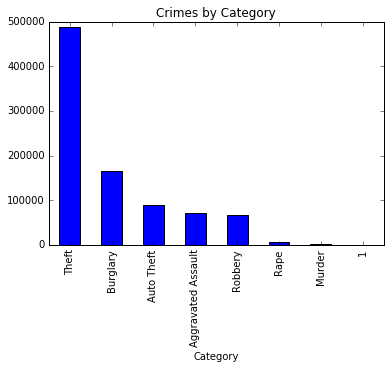

In [98]:
# crimes by category

%matplotlib inline
import matplotlib.pyplot as plt

groups = df.groupby("Category")["Category"].count()
groups = groups.sort_values(ascending=False)
plt.figure()
groups.plot(kind='bar', title="Crimes by Category")

Does crime distribution change by the day of the week?

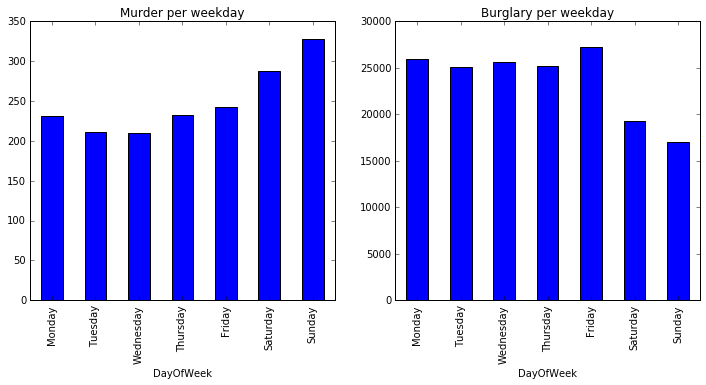

In [101]:
fig, axs = plt.subplots(1,2)

weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

df_murder = df[df.Category == "Murder"]
gr_murder = df_murder.groupby("DayOfWeek")["Offenses"].sum()
gr_murder = gr_murder[weekdays]

df_burglary = df[df.Category == "Burglary"]
gr_burglary = df_burglary.groupby("DayOfWeek")["Offenses"].sum()
gr_burglary = gr_burglary[weekdays]

gr_murder.plot(kind="bar", title="Murder per weekday", ax=axs[0])
gr_burglary.plot(kind="bar", title="Burglary per weekday", ax=axs[1], figsize=(12, 5))

Which crimes occur during which part of the day?

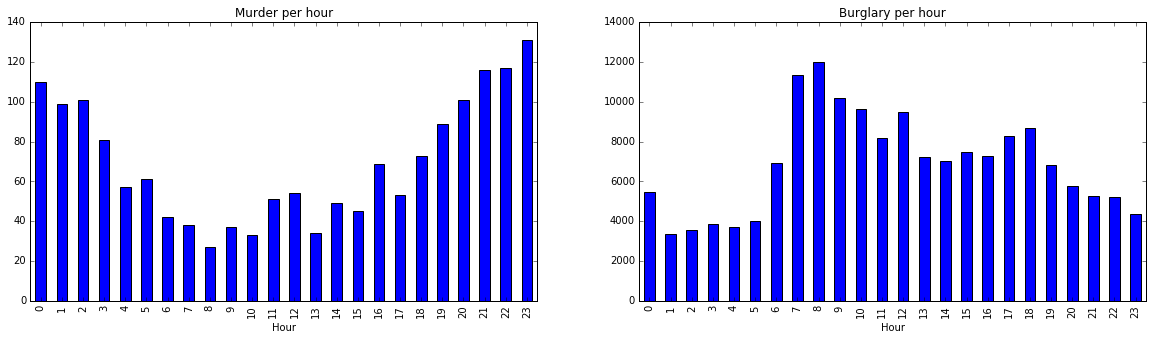

In [102]:
# thefts and burglaries by hour
fig, axs = plt.subplots(1,2)
hours = [x for x in range(24)]
df_theft = df[df.Category == "Murder"]
gr_theft = df_theft.groupby("Hour")["Category"].count()
gr_theft = gr_theft[hours]

df_burglary = df[df.Category == "Burglary"]
gr_burglary = df_burglary.groupby("Hour")["Category"].count()
gr_burglary = gr_burglary[hours]

gr_theft.plot(kind="bar", title="Murder per hour", ax=axs[0])
gr_burglary.plot(kind="bar", title="Burglary per hour", ax=axs[1], figsize=(20, 5))

## Big data analytics

GeoAnalytics provides a set of powerful tools for performing spatial analysis on big data. GeoAnalytics Tools are powered by your ArcGIS GeoAnalytics Server. ArcGIS GeoAnalytics Server distributes the analysis between multiple server nodes. By using distributed processing, you can process large datasets in less time.

### Find hot spots of crime

The “Find Hot Spots” tool can be used to identify statistically significant clusters of crime.

We can automate the creation of hotspots for all crime categories, across the years and create persisted information products in the form of web layers:

In [209]:
from arcgis.geoanalytics.analyze_patterns import find_hot_spots
arcgis.env.process_spatial_reference=32611
arcgis.env.verbose = False

In [260]:
for category in df.Category.unique()[:-1]:
    lyrid = 0
    for year in range(2010, 2017):
        output_name='Houston_' + category.replace(' ', '_') + '_Hotspot_' + str(year)
        print('Generating ' + output_name)
        layer = houston_yearly.layers[lyrid]
        layer.filter = "Category='{}'".format(category)
        
        find_hot_spots(layer, bin_size=0.5, bin_size_unit='Miles', 
                       neighborhood_distance=1, neighborhood_distance_unit='Miles', output_name=output_name)
        
        lyrid = lyrid + 1

Generating Houston_Aggravated_Assault_Hotspot_2010
Generating Houston_Aggravated_Assault_Hotspot_2011
Generating Houston_Aggravated_Assault_Hotspot_2012
Generating Houston_Aggravated_Assault_Hotspot_2013
Generating Houston_Aggravated_Assault_Hotspot_2014
Generating Houston_Aggravated_Assault_Hotspot_2015
Generating Houston_Aggravated_Assault_Hotspot_2016
Generating Houston_Burglary_Hotspot_2010
Generating Houston_Burglary_Hotspot_2011
Generating Houston_Burglary_Hotspot_2012
Generating Houston_Burglary_Hotspot_2013
Generating Houston_Burglary_Hotspot_2014
Generating Houston_Burglary_Hotspot_2015
Generating Houston_Burglary_Hotspot_2016
Generating Houston_Murder_Hotspot_2010
Generating Houston_Murder_Hotspot_2011
Generating Houston_Murder_Hotspot_2012
Generating Houston_Murder_Hotspot_2013
Generating Houston_Murder_Hotspot_2014
Generating Houston_Murder_Hotspot_2015
Generating Houston_Murder_Hotspot_2016
Generating Houston_Rape_Hotspot_2010
Generating Houston_Rape_Hotspot_2011
Generatin

##### Compare Burglary hot spots with auto-theft hot spots

In [4]:
hotmap1 = gis.map(houston, 10)
hotmap1.add_layer(gis.content.search('Houston_Burglary_Hotspot_2016')[0])
hotmap2 = gis.map(houston, 10)
hotmap2.add_layer(gis.content.search('Houston_Auto_Theft_Hotspot_2016')[0])

hotmap1.layout=Layout(flex='1 1', padding='3px')
hotmap2.layout=Layout(flex='1 1', padding='3px')

items_layout = Layout(flex='1 1 auto', width='auto')

display(HBox([hotmap1, hotmap2]))
display(HBox(children=[Button(description='Burglary hot spots in 2016', layout=items_layout, button_style='danger'),
                       Button(description='Auto theft hot spots in 2016', layout=items_layout, button_style='danger')],
             layout=Layout(width='100%')))

##### Compare hot spots over time

In [5]:
maps = []
labels = []
items_layout = Layout(flex='1 1 auto', width='auto')
for year in range(2014, 2017):
    layer = gis.content.search('Houston_Auto_Theft_Hotspot_'+str(year))[0]
    hotspotmap = gis.map(houston)
    hotspotmap.add_layer(layer)
    hotspotmap.layout=Layout(flex='1 1', padding='3px')
    maps.append(hotspotmap)
    hotspotmap.basemap='gray'
    labels.append(Button(description='Auto theft hot spots in ' + str(year), layout=items_layout, button_style='danger'))
    
layout=Layout(height='300px')
display(HBox([maps[0], maps[1], maps[2]], layout=layout))
display(HBox(children=labels, layout=Layout(width='100%')))

The hot spots in each category are strikingly similar across years. The hot spots of yesterday are the hotspots of tomorrow, and this information can be used to deploy officers and to identify areas in need of intervention.

## Aggregate crimes into police beats

<Item title:"Houston Police Beats" type:Feature Layer Collection owner:admin>
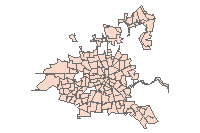

In [12]:
items = gis.content.search('Houston Police Beats', 'feature layer')
for item in items:
    display(item)

In [13]:
police_beats = items[0]

In [ ]:
from arcgis.geoanalytics.summarize_data import aggregate_points
arcgis.env.verbose = True

aggregate_points(houston_crime.layers[0]._lyr_dict, polygon_layer=police_beats, output_name='Houston Aggregated Crimes')

In [6]:
aggr_lyr = gis.content.search('Houston Aggregated Crimes')[0]
aggr_lyr

<Item title:"Houston Aggregated Crimes" type:Feature Layer Collection owner:admin>

### Visualize crime aggregated by police beat

In [7]:
beats_map = gis.map(houston, 11)
beats_map

In [8]:
beats_map.basemap = 'gray'

In [9]:
beats_map.add_layer(aggr_lyr, {
                        "renderer":"ClassedColorRenderer",
                        "field_name":"SUM_Offenses", 
                        "classificationMethod":'natural-breaks',
                        "numClasses":10,
                        "opacity":0.75
                      })

### Visualize aggregation results using plots

In [84]:
aggr_df = aggr_lyr.layers[0].query().sdf

In [85]:
aggr_df = aggr_df[['beats_0', 'SUM_Offenses']]
aggr_df.set_index('beats_0', inplace=True)
aggr_df.sort_values('SUM_Offenses', ascending=False).head(6)

,SUM_Offenses
beats_0,
01A10,28528.0
12D10,18820.0
19G10,16688.0
13D20,16609.0
06B60,16322.0
01A20,16294.0


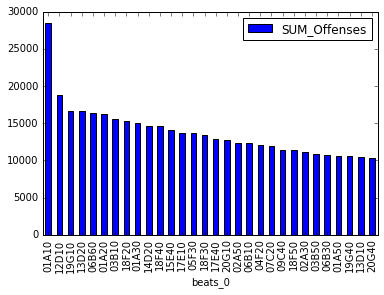

In [88]:
%matplotlib inline
aggr_df.sort_values('SUM_Offenses', ascending=False).head(30).plot(kind='bar')

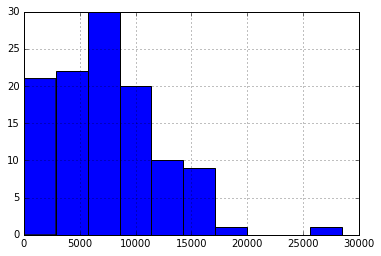

In [83]:
%matplotlib inline
aggr_df['SUM_Offenses'].hist()

# Predictive analysis using Machine Learning

### Feature engineering using data enrichment

In [89]:
from arcgis.features import enrich_data

In [90]:
enriched_houston = enrich_data.enrich_layer(police_beats, data_collections = ["KeyUSFacts"], 
                                            analysis_variables=["AtRisk.AVGHINC_CY","KeyUSFacts.DIVINDX_CY"])

Submitted.
Executing...


In [166]:
analysis_variables = [
    'TOTPOP_CY',  # 2016 Population: Total Population (Esri)
    'HHPOP_CY',   # 2016 Household Population (Esri)
    'FAMPOP_CY',  # 2016 Family Population (Esri)
    'DIVINDX_CY', # 2016 Diversity Index (Esri)
    'TOTHH_CY',   # 2016 Total Households (Esri)
    'AVGHHSZ_CY', # 2016 Average Household Size (Esri)

    'MALES_CY',   # 2016 Gender: Male Population (Esri)
    'FEMALES_CY', # 2016 Gender: Female Population (Esri)
    
    'MEDAGE_CY',  # 2016 Age: Median Age (Esri)
    
    'AVGFMSZ_CY', # 2016 Income: Average Family Size (Esri)
    'MEDHINC_CY', # 2016 Income: Median Household Income (Esri)
    'AVGHINC_CY', # 2016 Income: Average Household Income (Esri)
        
    'EDUCBASECY', # 2016 Educational Attainment Base (Esri)
    'NOHS_CY',    # 2016 Education: Less than 9th Grade (Esri)
    'SOMEHS_CY',  # 2016 Education: 9-12th Grade/No Diploma (Esri)
    'HSGRAD_CY',  # 2016 Education: High School Diploma (Esri)
    'GED_CY',     # 2016 Education: GED/Alternative Credential (Esri)
    'SMCOLL_CY',  # 2016 Education: Some College/No Degree (Esri)
    'ASSCDEG_CY', # 2016 Education: Associate's Degree (Esri)
    'BACHDEG_CY', # 2016 Education: Bachelor's Degree (Esri)
]

In [167]:
enriched_crime = enrich_data.enrich_layer(police_beats,
                                          analysis_variables=analysis_variables)

Submitted.
Executing...


In [170]:
enriched_df = enriched_crime.query().sdf
enriched_df.head()

,ASSCDEG_CY,AVGFMSZ_CY,AVGHHSZ_CY,AVGHINC_CY,BACHDEG_CY,DIVINDX_CY,EDUCBASECY,ENRICH_FID,FAMPOP_CY,FEMALES_CY,...,objectid_1,objectid_12,perimet_mi,shape_leng,shape_st_1,shape_st_2,shape_star,shape_stle,sourceCountry,SHAPE
0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1,1,9.254984,48866.313742,8.473145e+07,48866.313742,8.473145e+07,48866.313742,US,"{'rings': [[[-10591016.05175769, 3454151.57706..."
1,0.0,3.57,2.29,93321.0,16.0,79.6,30.0,2.0,25.0,14.0,...,2,2,7.153639,37771.213441,5.921056e+07,37771.213441,5.921056e+07,37771.213441,US,"{'rings': [[[-10605043.981271267, 3459581.0059..."
2,545.0,2.34,1.35,99836.0,1142.0,72.8,12007.0,3.0,818.0,2482.0,...,3,3,6.236709,32929.823999,4.868851e+07,32929.823996,4.868851e+07,32929.823996,US,"{'rings': [[[-10614376.898870792, 3473632.3481..."
3,869.0,2.55,1.64,112053.0,8333.0,63.8,20489.0,4.0,10231.0,11424.0,...,4,4,7.951329,41993.698682,6.803877e+07,41983.018467,6.803877e+07,41983.018467,US,"{'rings': [[[-10617740.97474497, 3473028.47709..."
4,709.0,2.55,1.66,123895.0,7777.0,60.6,21564.0,5.0,12226.0,12827.0,...,5,5,8.016405,42379.151925,7.406897e+07,42326.621053,7.406897e+07,42326.621053,US,"{'rings': [[[-10619905.80550302, 3471864.28871..."


In [171]:
enriched_df.columns

Index(['ASSCDEG_CY', 'AVGFMSZ_CY', 'AVGHHSZ_CY', 'AVGHINC_CY', 'BACHDEG_CY',
       'DIVINDX_CY', 'EDUCBASECY', 'ENRICH_FID', 'FAMPOP_CY', 'FEMALES_CY',
       'GED_CY', 'HHPOP_CY', 'HSGRAD_CY', 'HasData', 'ID', 'MALES_CY',
       'MEDAGE_CY', 'MEDHINC_CY', 'NOHS_CY', 'SMCOLL_CY', 'SOMEHS_CY',
       'TOTHH_CY', 'TOTPOP_CY', 'aggregationMethod', 'area_sq_mi', 'beats',
       'beats_0', 'district', 'objectid', 'objectid_1', 'objectid_12',
       'perimet_mi', 'shape_leng', 'shape_st_1', 'shape_st_2', 'shape_star',
       'shape_stle', 'sourceCountry', 'SHAPE'],
      dtype='object')

In [173]:
edf = enriched_df[['beats_0'] + analysis_variables]

### Merge with original crime dataframe

In [175]:
merged_df = df.merge(edf, left_on='Beat', right_on='beats_0')
merged_df.columns

Index(['OBJECTID', 'Date', 'Hour', 'DayOfWeek', 'Category', 'Offenses', 'Beat',
       'Address', 'X', 'Y', 'SHAPE', 'beats_0', 'TOTPOP_CY', 'HHPOP_CY',
       'FAMPOP_CY', 'DIVINDX_CY', 'TOTHH_CY', 'AVGHHSZ_CY', 'MALES_CY',
       'FEMALES_CY', 'MEDAGE_CY', 'AVGFMSZ_CY', 'MEDHINC_CY', 'AVGHINC_CY',
       'EDUCBASECY', 'NOHS_CY', 'SOMEHS_CY', 'HSGRAD_CY', 'GED_CY',
       'SMCOLL_CY', 'ASSCDEG_CY', 'BACHDEG_CY'],
      dtype='object')

### Apply machine learning using Scikit-learn

In [177]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import log_loss
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
import numpy as np

In [178]:
df = merged_df
df.Category.unique()

array(['Aggravated Assault', 'Burglary', 'Robbery', 'Auto Theft', 'Theft',
       'Rape', 'Murder', '1'], dtype=object)

In [179]:
df = df[df.Category != '1']
df = df[df.DayOfWeek != '']

offence_encoder = preprocessing.LabelEncoder()
offences = offence_encoder.fit_transform(df['Category'])

hour = pd.get_dummies(df.Hour, prefix="hour")
day = pd.get_dummies(df.DayOfWeek, prefix="day")
beats = pd.get_dummies(df.Beat, prefix="beats")

In [180]:
offence_encoder = preprocessing.LabelEncoder()
offences = offence_encoder.fit_transform(df['Category'])

In [210]:
data = pd.concat([hour, day, beats], axis=1)

In [211]:
data['Violent'] = df['Category'].apply(lambda x : 1 if x in ['Murder', 'Rape', 'Aggravated Assault'] else 0)

### Test SVC classifier on subset of data

In [206]:
data = data[:1000]

In [207]:
training, validation = train_test_split(data, train_size=.75)

In [208]:
features = list(training.columns)[:-1]

In [209]:
from sklearn.svm import SVC

svc = SVC()
svc.fit(training[features], training.Violent)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [189]:
svc.score(training[features], training.Violent)

0.79600000000000004

In [190]:
svc.score(validation[features], validation.Violent)

0.78800000000000003

### Run model using entire data

In [212]:
data = pd.concat([hour, day, beats], axis=1)
data['Violent'] = df['Category'].apply(lambda x : 1 if x in ['Murder', 'Rape', 'Aggravated Assault'] else 0)

In [213]:
training, validation = train_test_split(data, train_size=.75)

In [214]:
features = list(training.columns)[:-1]

In [215]:
from sklearn.svm import SVC

svc = SVC()
svc.fit(training[features], training.Violent)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

### Check accuracy of SVC classifier

In [216]:
svc.score(training[features], training.Violent)

0.91283468584793992

In [217]:
svc.score(validation[features], validation.Violent)

0.91278333372186093